# About this notebook
- inspired from https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train

# Directory settings

In [1]:
# ====================================================
# Directory settings
# ====================================================
import os

INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# CFG

In [2]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=False
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="anferico/bert-for-patents" #"microsoft/deberta-v3-small" #"anferico/bert-for-patents"
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=0
    epochs=12
    encoder_lr=2e-5
    decoder_lr=2e-5
    min_lr=1e-6
    eps=1e-6
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.2
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=42
    n_fold=4
    trn_fold=[0]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [3]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    
    import wandb

    try:
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        secret_value_0 = user_secrets.get_secret("wandb_api")
        wandb.login(key=secret_value_0)
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-Public', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

# Library

In [4]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

os.system('pip uninstall -y transformers')
os.system('pip uninstall -y tokenizers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels transformers')
os.system('python -m pip install --no-index --find-links=../input/pppm-pip-wheels tokenizers')
import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.9.1
Found existing installation: transformers 4.16.2
Uninstalling transformers-4.16.2:
  Successfully uninstalled transformers-4.16.2


Found existing installation: tokenizers 0.11.6
Uninstalling tokenizers-0.11.6:
  Successfully uninstalled tokenizers-0.11.6


Looking in links: ../input/pppm-pip-wheels
Processing /kaggle/input/pppm-pip-wheels/transformers-4.18.0-py3-none-any.whl
Processing /kaggle/input/pppm-pip-wheels/tokenizers-0.12.1-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.1 requires transformers<4.17,>=4.1, but you have transformers 4.18.0 which is incompatible.


Looking in links: ../input/pppm-pip-wheels


tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


# Utils

In [5]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [6]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv(INPUT_DIR+'train.csv')
test = pd.read_csv(INPUT_DIR+'test.csv')
submission = pd.read_csv(INPUT_DIR+'sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [7]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [8]:
train['text'] = train['anchor'] + '[SEP]' + train['target'] #+ '[SEP]'  + train['context_text']
test['text'] = test['anchor'] + '[SEP]' + test['target'] #+ '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural network


# EDA

<AxesSubplot:>

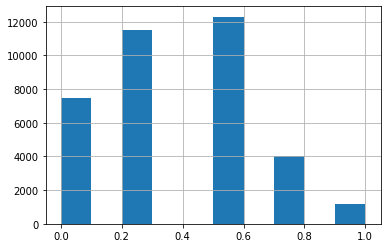

In [9]:
train['score'].hist()

In [10]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

- Y is not in training data, but may be in test data?

# CV split

In [11]:
# ====================================================
# CV split
# ====================================================
train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby('fold').size())

fold
0    9119
1    9118
2    9118
3    9118
dtype: int64

In [12]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# tokenizer

In [13]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

Downloading:   0%|          | 0.00/327 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/322k [00:00<?, ?B/s]

# Dataset

In [14]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target']) + 3 + 3
#                 + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 60


In [15]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [16]:
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)


{'input_ids': tensor([    2, 35736,     3, 35736,  1662, 10461,     3,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
tensor(0.5000)


# Model

In [17]:
from transformers import BertModel
from transformers.models.bert.modeling_bert import BertAttention, BertLayer
from transformers.modeling_outputs  import BaseModelOutputWithPastAndCrossAttentions

In [18]:
import torch.nn as nn
from typing import List, Optional, Tuple, Union
import math

######## TODO
# first check using no attention masks
# then try different ones ->  attention mask needs to be such that the encoder's padding tokens are not attended to.

class BertCrossAttention(nn.Module):
    def __init__(self, config, position_embedding_type=None):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size ({config.hidden_size}) is not a multiple of the number of attention "
                f"heads ({config.num_attention_heads})"
            )

        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size

        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)
        self.position_embedding_type = position_embedding_type or getattr(
            config, "position_embedding_type", "absolute"
        )
        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            self.max_position_embeddings = config.max_position_embeddings
            self.distance_embedding = nn.Embedding(2 * config.max_position_embeddings - 1, self.attention_head_size)

    def transpose_for_scores(self, x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        encoder_hidden_states: Optional[torch.FloatTensor] = None,
        encoder_attention_mask: Optional[torch.FloatTensor] = None,
        past_key_value: Optional[Tuple[Tuple[torch.FloatTensor]]] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
    
        mixed_query_layer = self.query(hidden_states)

        # If this is instantiated as a cross-attention module, the keys
        # and values come from an encoder; the attention mask needs to be
        # such that the encoder's padding tokens are not attended to.
        
        # TODO: need to check this out about encoders padding tokens
        is_cross_attention = encoder_hidden_states is not None

        # cross attention key value
        key_layer = self.transpose_for_scores(self.key(encoder_hidden_states))
        value_layer = self.transpose_for_scores(self.value(encoder_hidden_states))
        attention_mask = encoder_attention_mask

        query_layer = self.transpose_for_scores(mixed_query_layer)

        use_cache = False

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

        if self.position_embedding_type == "relative_key" or self.position_embedding_type == "relative_key_query":
            query_length, key_length = query_layer.shape[2], key_layer.shape[2]
            if use_cache:
                position_ids_l = torch.tensor(key_length - 1, dtype=torch.long, device=hidden_states.device).view(
                    -1, 1
                )
            else:
                position_ids_l = torch.arange(query_length, dtype=torch.long, device=hidden_states.device).view(-1, 1)
            position_ids_r = torch.arange(key_length, dtype=torch.long, device=hidden_states.device).view(1, -1)
            distance = position_ids_l - position_ids_r

            positional_embedding = self.distance_embedding(distance + self.max_position_embeddings - 1)
            positional_embedding = positional_embedding.to(dtype=query_layer.dtype)  # fp16 compatibility

            if self.position_embedding_type == "relative_key":
                relative_position_scores = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores
            elif self.position_embedding_type == "relative_key_query":
                relative_position_scores_query = torch.einsum("bhld,lrd->bhlr", query_layer, positional_embedding)
                relative_position_scores_key = torch.einsum("bhrd,lrd->bhlr", key_layer, positional_embedding)
                attention_scores = attention_scores + relative_position_scores_query + relative_position_scores_key

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in BertModel forward() function)
            attention_scores = attention_scores + attention_mask

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
        return outputs



In [19]:
class BertSelfOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.LayerNorm_sc = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.cross_attention = BertCrossAttention(config)
        self.alpha1 = torch.nn.Parameter(torch.tensor(0.1))
        self.alpha2 = torch.nn.Parameter(torch.tensor(0.9))
        print("Using SC in residual.")
        print(self.alpha1.requires_grad, self.alpha2.requires_grad)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        
        
        hidden_states_cross_out = self.cross_attention(
                            hidden_states = hidden_states,
                            encoder_hidden_states = input_tensor
                        )[0]

        input_tensor_cross_out = self.cross_attention(
            hidden_states = input_tensor,
            encoder_hidden_states = hidden_states
        )[0]
        
#         print("Output : ", hidden_states_cross_out.shape, input_tensor_cross_out.shape)
        total = self.alpha1 + self.alpha2
        hidden_states = (self.alpha1 / total) * self.LayerNorm_sc(hidden_states_cross_out + input_tensor_cross_out) + (self.alpha2 / total) * self.LayerNorm(hidden_states + input_tensor)
        return hidden_states

In [20]:
def intersect_dicts(da, db, exclude=()):
    # Dictionary intersection of matching keys and shapes, omitting 'exclude' keys, using da values
    return {k: v for k, v in da.items() if k in db and all(x not in k for x in exclude) and v.shape == db[k].shape}

In [21]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = BertModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        # freeze full model
        for name, para in self.model.named_parameters():
            para.requires_grad = False
        
        # changing to sc blocks
        total_layers = len(self.model.encoder.layer)
        for i, layer in enumerate(self.model.encoder.layer):
            if i in [14, 18, 19, 20, 23]:
                print("Adding SC in layer: ", i)
                new_layer = BertSelfOutput(self.config)
                csd = layer.attention.output.state_dict()
                out_sd = intersect_dicts(csd, new_layer.state_dict())
                new_layer.load_state_dict(out_sd, strict=False)

                print(csd.keys(), new_layer.state_dict().keys())
                print(f'{i}: Transferred {len(csd)}/{len(new_layer.state_dict())} items')
                layer.attention.output = new_layer
                
                # unfreeze layer
                for name, para in new_layer.named_parameters():
                    para.requires_grad = True
            
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output

# Helpler functions

In [22]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [23]:
def get_trainable_param_count(model):
    count = 0
    for name, para in model.named_parameters():
        count += para.requires_grad
    return count

In [24]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)
    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss(reduction="mean")
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()
        
        if epoch == 2:
            print("UNFREEZING ALL PARAMS")
            for name, para in model.named_parameters():
                para.requires_grad = True

        print("Unfrozen paramsize: ", get_trainable_param_count(model))

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")

    predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds['pred'] = predictions

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [25]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Downloading:   0%|          | 0.00/1.29G [00:00<?, ?B/s]

Some weights of the model checkpoint at anferico/bert-for-patents were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adding SC in layer:  14
Using SC in residual.
True True
odict_keys(['dense.weight', 'dense.bias', 'LayerNorm.weight', 'LayerNorm.bias']) odict_keys(['alpha1', 'alpha2', 'dense.weight', 'dense.bias', 'LayerNorm.weight', 'LayerNorm.bias', 'LayerNorm_sc.weight', 'LayerNorm_sc.bias', 'cross_attention.query.weight', 'cross_attention.query.bias', 'cross_attention.key.weight', 'cross_attention.key.bias', 'cross_attention.value.weight', 'cross_attention.value.bias'])
14: Transferred 4/14 items
Adding SC in layer:  18
Using SC in residual.
True True
odict_keys(['dense.weight', 'dense.bias', 'LayerNorm.weight', 'LayerNorm.bias']) odict_keys(['alpha1', 'alpha2', 'dense.weight', 'dense.bias', 'LayerNorm.weight', 'LayerNorm.bias', 'LayerNorm_sc.weight', 'LayerNorm_sc.bias', 'cross_attention.query.weight', 'cross_attention.query.bias', 'cross_attention.key.weight', 'cross_attention.key.bias', 'cross_attention.value.weight', 'cross_attention.value.bias'])
18: Transferred 4/14 items
Adding SC in layer

Epoch 1 - avg_train_loss: 0.6306  avg_val_loss: 0.6048  time: 432s
Epoch 1 - Score: 0.5818
Epoch 1 - Save Best Score: 0.5818 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6907(0.6048) 
Unfrozen paramsize:  76
Epoch: [2][0/1709] Elapsed 0m 0s (remain 15m 13s) Loss: 0.5801(0.5801) Grad: 68715.9375  LR: 0.00001966  
Epoch: [2][100/1709] Elapsed 0m 21s (remain 5m 46s) Loss: 0.5902(0.6123) Grad: 43596.1133  LR: 0.00001962  
Epoch: [2][200/1709] Elapsed 0m 42s (remain 5m 21s) Loss: 0.5833(0.6122) Grad: 81894.1797  LR: 0.00001958  
Epoch: [2][300/1709] Elapsed 1m 4s (remain 4m 59s) Loss: 0.6650(0.6107) Grad: 66636.0000  LR: 0.00001953  
Epoch: [2][400/1709] Elapsed 1m 25s (remain 4m 37s) Loss: 0.6063(0.6085) Grad: 63043.7227  LR: 0.00001948  
Epoch: [2][500/1709] Elapsed 1m 46s (remain 4m 16s) Loss: 0.6656(0.6088) Grad: 117444.2188  LR: 0.00001943  
Epoch: [2][600/1709] Elapsed 2m 7s (remain 3m 54s) Loss: 0.6043(0.6095) Grad: 86506.6094  LR: 0.00001938  
Epoch: [2][700/1709] Elapsed 2m 28s (remain 3m 33s) Loss: 0.6222(0.6071) Grad: 81166.1250  LR: 0.00001933  
Epoch: [2][800/1709] Elapsed 2m 49s (remain 3m 1

Epoch 2 - avg_train_loss: 0.6060  avg_val_loss: 0.5956  time: 431s
Epoch 2 - Score: 0.6248
Epoch 2 - Save Best Score: 0.6248 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.6376(0.5956) 
UNFREEZING ALL PARAMS
Unfrozen paramsize:  447
Epoch: [3][0/1709] Elapsed 0m 0s (remain 19m 11s) Loss: 0.6420(0.6420) Grad: 238227.4688  LR: 0.00001866  
Epoch: [3][100/1709] Elapsed 0m 46s (remain 12m 26s) Loss: 0.5636(0.6164) Grad: 76935.0781  LR: 0.00001858  
Epoch: [3][200/1709] Elapsed 1m 33s (remain 11m 39s) Loss: 0.6941(0.6107) Grad: 56430.2930  LR: 0.00001850  
Epoch: [3][300/1709] Elapsed 2m 19s (remain 10m 52s) Loss: 0.5608(0.6019) Grad: 17535.9805  LR: 0.00001842  
Epoch: [3][400/1709] Elapsed 3m 5s (remain 10m 5s) Loss: 0.6740(0.5927) Grad: 43319.1562  LR: 0.00001834  
Epoch: [3][500/1709] Elapsed 3m 52s (remain 9m 19s) Loss: 0.5210(0.5898) Grad: 11208.0576  LR: 0.00001825  
Epoch: [3][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.4313(0.5866) Grad: 25768.1074  LR: 0.00001817  
Epoch: [3][700/1709] Elapsed 5m 24s (remain 7m 46s) Loss: 0.5524(0.5854) Grad: 29550.9062  LR: 0.00001808  
Epoch: [3][800/1709] 

Epoch 3 - avg_train_loss: 0.5673  avg_val_loss: 0.5405  time: 861s
Epoch 3 - Score: 0.8279
Epoch 3 - Save Best Score: 0.8279 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5409(0.5405) 
Unfrozen paramsize:  447
Epoch: [4][0/1709] Elapsed 0m 0s (remain 19m 28s) Loss: 0.4050(0.4050) Grad: 55878.9219  LR: 0.00001707  
Epoch: [4][100/1709] Elapsed 0m 47s (remain 12m 28s) Loss: 0.5164(0.5190) Grad: 245193.7656  LR: 0.00001696  
Epoch: [4][200/1709] Elapsed 1m 33s (remain 11m 40s) Loss: 0.5077(0.5217) Grad: 130092.0391  LR: 0.00001685  
Epoch: [4][300/1709] Elapsed 2m 19s (remain 10m 53s) Loss: 0.5746(0.5224) Grad: 107452.5000  LR: 0.00001674  
Epoch: [4][400/1709] Elapsed 3m 5s (remain 10m 6s) Loss: 0.5987(0.5222) Grad: 67391.4844  LR: 0.00001663  
Epoch: [4][500/1709] Elapsed 3m 52s (remain 9m 19s) Loss: 0.5862(0.5201) Grad: 82594.0078  LR: 0.00001651  
Epoch: [4][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.5203(0.5185) Grad: 130391.6641  LR: 0.00001639  
Epoch: [4][700/1709] Elapsed 5m 24s (remain 7m 47s) Loss: 0.5513(0.5188) Grad: 99329.7266  LR: 0.00001627  
Epoch: [4][800/1709] Elapsed 6m 11s (rem

Epoch 4 - avg_train_loss: 0.5192  avg_val_loss: 0.5402  time: 861s
Epoch 4 - Score: 0.8468
Epoch 4 - Save Best Score: 0.8468 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5121(0.5402) 
Unfrozen paramsize:  447
Epoch: [5][0/1709] Elapsed 0m 0s (remain 18m 47s) Loss: 0.6089(0.6089) Grad: 256699.9844  LR: 0.00001500  
Epoch: [5][100/1709] Elapsed 0m 47s (remain 12m 28s) Loss: 0.6487(0.5149) Grad: 63888.0469  LR: 0.00001487  
Epoch: [5][200/1709] Elapsed 1m 33s (remain 11m 40s) Loss: 0.5788(0.5110) Grad: 54603.5039  LR: 0.00001473  
Epoch: [5][300/1709] Elapsed 2m 19s (remain 10m 53s) Loss: 0.3557(0.5101) Grad: 62014.6133  LR: 0.00001460  
Epoch: [5][400/1709] Elapsed 3m 5s (remain 10m 6s) Loss: 0.5388(0.5078) Grad: 68830.9375  LR: 0.00001446  
Epoch: [5][500/1709] Elapsed 3m 52s (remain 9m 19s) Loss: 0.4885(0.5084) Grad: 29852.3301  LR: 0.00001432  
Epoch: [5][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.5926(0.5082) Grad: 73042.8359  LR: 0.00001419  
Epoch: [5][700/1709] Elapsed 5m 24s (remain 7m 46s) Loss: 0.4537(0.5072) Grad: 294437.8750  LR: 0.00001405  
Epoch: [5][800/1709] Elapsed 6m 11s (remai

Epoch 5 - avg_train_loss: 0.5093  avg_val_loss: 0.5434  time: 861s
Epoch 5 - Score: 0.8481
Epoch 5 - Save Best Score: 0.8481 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5062(0.5434) 
Unfrozen paramsize:  447
Epoch: [6][0/1709] Elapsed 0m 0s (remain 19m 8s) Loss: 0.6304(0.6304) Grad: 146731.3438  LR: 0.00001259  
Epoch: [6][100/1709] Elapsed 0m 47s (remain 12m 28s) Loss: 0.5158(0.5007) Grad: 196362.1094  LR: 0.00001244  
Epoch: [6][200/1709] Elapsed 1m 33s (remain 11m 41s) Loss: 0.4184(0.5016) Grad: 77073.1406  LR: 0.00001229  
Epoch: [6][300/1709] Elapsed 2m 19s (remain 10m 54s) Loss: 0.4348(0.4979) Grad: 123929.3750  LR: 0.00001214  
Epoch: [6][400/1709] Elapsed 3m 6s (remain 10m 7s) Loss: 0.5377(0.5006) Grad: 105225.8984  LR: 0.00001199  
Epoch: [6][500/1709] Elapsed 3m 52s (remain 9m 20s) Loss: 0.5389(0.4985) Grad: 319783.1875  LR: 0.00001184  
Epoch: [6][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.5808(0.4991) Grad: 45103.4922  LR: 0.00001169  
Epoch: [6][700/1709] Elapsed 5m 24s (remain 7m 47s) Loss: 0.6086(0.5016) Grad: 20203.9688  LR: 0.00001154  
Epoch: [6][800/1709] Elapsed 6m 11s (rem

Epoch 6 - avg_train_loss: 0.5038  avg_val_loss: 0.5448  time: 861s
Epoch 6 - Score: 0.8464


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4989(0.5448) 
Unfrozen paramsize:  447
Epoch: [7][0/1709] Elapsed 0m 0s (remain 20m 0s) Loss: 0.4741(0.4741) Grad: 41329.5156  LR: 0.00001000  
Epoch: [7][100/1709] Elapsed 0m 47s (remain 12m 29s) Loss: 0.3455(0.4917) Grad: 28628.7188  LR: 0.00000985  
Epoch: [7][200/1709] Elapsed 1m 33s (remain 11m 40s) Loss: 0.3016(0.4956) Grad: 21484.3125  LR: 0.00000970  
Epoch: [7][300/1709] Elapsed 2m 19s (remain 10m 53s) Loss: 0.4198(0.4958) Grad: 457669.7188  LR: 0.00000954  
Epoch: [7][400/1709] Elapsed 3m 6s (remain 10m 6s) Loss: 0.3909(0.4962) Grad: 47327.4219  LR: 0.00000939  
Epoch: [7][500/1709] Elapsed 3m 52s (remain 9m 20s) Loss: 0.5972(0.4964) Grad: 33373.1953  LR: 0.00000924  
Epoch: [7][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.4885(0.4956) Grad: 45321.9414  LR: 0.00000909  
Epoch: [7][700/1709] Elapsed 5m 25s (remain 7m 47s) Loss: 0.5250(0.4948) Grad: 59951.0547  LR: 0.00000893  
Epoch: [7][800/1709] Elapsed 6m 11s (remain 

Epoch 7 - avg_train_loss: 0.4957  avg_val_loss: 0.5475  time: 861s
Epoch 7 - Score: 0.8518
Epoch 7 - Save Best Score: 0.8518 Model


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5063(0.5475) 
Unfrozen paramsize:  447
Epoch: [8][0/1709] Elapsed 0m 0s (remain 19m 17s) Loss: 0.3644(0.3644) Grad: 232289.4219  LR: 0.00000742  
Epoch: [8][100/1709] Elapsed 0m 47s (remain 12m 28s) Loss: 0.5187(0.4789) Grad: 87822.0859  LR: 0.00000727  
Epoch: [8][200/1709] Elapsed 1m 33s (remain 11m 38s) Loss: 0.4010(0.4834) Grad: 20460.7559  LR: 0.00000712  
Epoch: [8][300/1709] Elapsed 2m 19s (remain 10m 52s) Loss: 0.6100(0.4852) Grad: 18184.9180  LR: 0.00000698  
Epoch: [8][400/1709] Elapsed 3m 5s (remain 10m 5s) Loss: 0.4787(0.4884) Grad: 20927.5020  LR: 0.00000683  
Epoch: [8][500/1709] Elapsed 3m 52s (remain 9m 19s) Loss: 0.3810(0.4883) Grad: 31531.7500  LR: 0.00000668  
Epoch: [8][600/1709] Elapsed 4m 38s (remain 8m 33s) Loss: 0.4257(0.4898) Grad: 22071.7520  LR: 0.00000654  
Epoch: [8][700/1709] Elapsed 5m 24s (remain 7m 46s) Loss: 0.4200(0.4886) Grad: 18033.6328  LR: 0.00000640  
Epoch: [8][800/1709] Elapsed 6m 10s (remain

Epoch 8 - avg_train_loss: 0.4921  avg_val_loss: 0.5549  time: 861s
Epoch 8 - Score: 0.8500


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5462(0.5549) 
Unfrozen paramsize:  447
Epoch: [9][0/1709] Elapsed 0m 0s (remain 21m 29s) Loss: 0.4239(0.4239) Grad: 69379.9453  LR: 0.00000500  
Epoch: [9][100/1709] Elapsed 0m 47s (remain 12m 33s) Loss: 0.4974(0.4879) Grad: 53117.6953  LR: 0.00000487  
Epoch: [9][200/1709] Elapsed 1m 33s (remain 11m 43s) Loss: 0.4739(0.4894) Grad: 67348.4453  LR: 0.00000474  
Epoch: [9][300/1709] Elapsed 2m 20s (remain 10m 55s) Loss: 0.4573(0.4921) Grad: 30018.5469  LR: 0.00000461  
Epoch: [9][400/1709] Elapsed 3m 6s (remain 10m 8s) Loss: 0.5924(0.4918) Grad: 118200.3125  LR: 0.00000448  
Epoch: [9][500/1709] Elapsed 3m 53s (remain 9m 21s) Loss: 0.5497(0.4905) Grad: 39459.0898  LR: 0.00000436  
Epoch: [9][600/1709] Elapsed 4m 39s (remain 8m 35s) Loss: 0.5497(0.4898) Grad: 57107.6680  LR: 0.00000423  
Epoch: [9][700/1709] Elapsed 5m 25s (remain 7m 48s) Loss: 0.5329(0.4893) Grad: 48552.0039  LR: 0.00000411  
Epoch: [9][800/1709] Elapsed 6m 12s (remain

Epoch 9 - avg_train_loss: 0.4874  avg_val_loss: 0.5580  time: 863s
Epoch 9 - Score: 0.8500


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4970(0.5580) 
Unfrozen paramsize:  447
Epoch: [10][0/1709] Elapsed 0m 0s (remain 20m 25s) Loss: 0.4297(0.4297) Grad: 37014.6836  LR: 0.00000293  
Epoch: [10][100/1709] Elapsed 0m 47s (remain 12m 29s) Loss: 0.4905(0.4885) Grad: 42849.5977  LR: 0.00000283  
Epoch: [10][200/1709] Elapsed 1m 33s (remain 11m 41s) Loss: 0.3864(0.4796) Grad: 21358.3594  LR: 0.00000272  
Epoch: [10][300/1709] Elapsed 2m 19s (remain 10m 54s) Loss: 0.4863(0.4804) Grad: 29399.4570  LR: 0.00000262  
Epoch: [10][400/1709] Elapsed 3m 6s (remain 10m 7s) Loss: 0.3687(0.4827) Grad: 65855.2031  LR: 0.00000251  
Epoch: [10][500/1709] Elapsed 3m 52s (remain 9m 21s) Loss: 0.4102(0.4834) Grad: 40042.2734  LR: 0.00000241  
Epoch: [10][600/1709] Elapsed 4m 39s (remain 8m 34s) Loss: 0.4331(0.4842) Grad: 128479.4844  LR: 0.00000231  
Epoch: [10][700/1709] Elapsed 5m 25s (remain 7m 48s) Loss: 0.5009(0.4849) Grad: 31917.4531  LR: 0.00000222  
Epoch: [10][800/1709] Elapsed 6m 12

Epoch 10 - avg_train_loss: 0.4851  avg_val_loss: 0.5597  time: 864s
Epoch 10 - Score: 0.8508


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5376(0.5597) 
Unfrozen paramsize:  447
Epoch: [11][0/1709] Elapsed 0m 0s (remain 21m 21s) Loss: 0.5016(0.5016) Grad: 19973.1211  LR: 0.00000134  
Epoch: [11][100/1709] Elapsed 0m 47s (remain 12m 30s) Loss: 0.3810(0.4757) Grad: 24397.2734  LR: 0.00000127  
Epoch: [11][200/1709] Elapsed 1m 33s (remain 11m 42s) Loss: 0.5289(0.4773) Grad: 42549.2188  LR: 0.00000119  
Epoch: [11][300/1709] Elapsed 2m 20s (remain 10m 55s) Loss: 0.4656(0.4831) Grad: 94278.8281  LR: 0.00000112  
Epoch: [11][400/1709] Elapsed 3m 6s (remain 10m 8s) Loss: 0.3993(0.4820) Grad: 19505.2578  LR: 0.00000105  
Epoch: [11][500/1709] Elapsed 3m 52s (remain 9m 21s) Loss: 0.4870(0.4836) Grad: 52895.9258  LR: 0.00000099  
Epoch: [11][600/1709] Elapsed 4m 39s (remain 8m 34s) Loss: 0.5692(0.4840) Grad: 23592.3867  LR: 0.00000092  
Epoch: [11][700/1709] Elapsed 5m 25s (remain 7m 48s) Loss: 0.4910(0.4847) Grad: 20066.6641  LR: 0.00000086  
Epoch: [11][800/1709] Elapsed 6m 12s

Epoch 11 - avg_train_loss: 0.4839  avg_val_loss: 0.5575  time: 863s
Epoch 11 - Score: 0.8510


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.4949(0.5575) 
Unfrozen paramsize:  447
Epoch: [12][0/1709] Elapsed 0m 0s (remain 21m 28s) Loss: 0.4152(0.4152) Grad: 24025.0586  LR: 0.00000034  
Epoch: [12][100/1709] Elapsed 0m 47s (remain 12m 30s) Loss: 0.5180(0.4720) Grad: 64177.1602  LR: 0.00000030  
Epoch: [12][200/1709] Elapsed 1m 33s (remain 11m 42s) Loss: 0.4249(0.4830) Grad: 17965.4902  LR: 0.00000027  
Epoch: [12][300/1709] Elapsed 2m 19s (remain 10m 54s) Loss: 0.4169(0.4825) Grad: 33155.4570  LR: 0.00000023  
Epoch: [12][400/1709] Elapsed 3m 6s (remain 10m 7s) Loss: 0.5370(0.4825) Grad: 25420.6250  LR: 0.00000020  
Epoch: [12][500/1709] Elapsed 3m 52s (remain 9m 21s) Loss: 0.4316(0.4814) Grad: 30446.1699  LR: 0.00000017  
Epoch: [12][600/1709] Elapsed 4m 39s (remain 8m 34s) Loss: 0.4781(0.4821) Grad: 141731.5000  LR: 0.00000015  
Epoch: [12][700/1709] Elapsed 5m 25s (remain 7m 48s) Loss: 0.4369(0.4831) Grad: 59066.6797  LR: 0.00000012  
Epoch: [12][800/1709] Elapsed 6m 11

Epoch 12 - avg_train_loss: 0.4832  avg_val_loss: 0.5588  time: 862s
Epoch 12 - Score: 0.8509


EVAL: [569/570] Elapsed 1m 9s (remain 0m 0s) Loss: 0.5067(0.5588) 


========== fold: 0 result ==========
Score: 0.8518
========== CV ==========
Score: 0.8518
